In [1]:
import json
from collections import Counter

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def match_rate(predictions_path: str, cluster_descriptions_path: str) -> float:
    """
    Calculate the match rate of predictions with cluster descriptions.
    Match rate is calculated as the proportion of predicted categories
    that exist in the cluster descriptions.

    :param predictions_path: Path to a JSON file containing predictions in the specified format.
                             Format: [
                                 ["category_1", "category_2", "predicted_category; ..."],
                                 ...
                             ]
    :param cluster_descriptions_path: Path to a JSON file containing valid cluster descriptions.
                                       Format: ["description_1", "description_2", ...]
    :return: Match rate as a float (between 0 and 1).
    """
    # Load predictions
    with open(predictions_path, "r", encoding="utf-8") as f:
        predictions = json.load(f)

    # Load cluster descriptions
    with open(cluster_descriptions_path, "r", encoding="utf-8") as f:
        cluster_descriptions = set(json.load(f))  # Convert to set for faster lookups

    # Initialize match counters
    total_matches = 0  # Total number of matches
    total_categories = 0  # Total number of predicted categories

    # Process predictions
    for prediction in predictions:
        # Extract the predicted categories and split by semicolon
        predicted_categories = prediction[2].split("; ")

        # Count matches and total predicted categories
        total_matches += sum(
            1 for pred in predicted_categories if pred in cluster_descriptions
        )
        total_categories += len(predicted_categories)

    # Calculate match rate
    match_rate = total_matches / total_categories if total_categories > 0 else 0.0

    return match_rate

In [3]:
def precision(predictions_path: str, interactions_path: str):
    """
    Calculate the precision of predictions based on actual user interactions.

    Precision is defined as the ratio of true positive predictions to the total number
    of predictions made (true positives + false positives).

    :param predictions_path: Path to the JSON file containing predictions.
                             The file should be in the format:
                             [
                                 ["user_category_1", "user_category_2", "predicted_category"],
                                 ...
                             ]
                             where `predicted_category` is a semicolon-separated string.

    :param interactions_path: Path to the CSV file containing actual user interactions.
                              The file should contain columns:
                              - "user_category_1"
                              - "user_category_2"
                              - "user_category_3"
                              where `user_category_3` represents the ground truth categories
                              as a single value per row.

    :return: Precision as a float value [0, 1].
    """
    # Step 1: Load the JSON file
    with open(predictions_path, "r", encoding="utf-8") as f:
        json_data = json.load(f)

    # Convert JSON into a DataFrame
    predicted_data = pd.DataFrame(
        json_data, columns=["user_category_1", "user_category_2", "predicted_category"]
    )

    actual_data = pd.read_csv(interactions_path, sep=",")

    # Step 3: Merge data on user_category_1 and user_category_2

    actual_test_data = pd.merge(
        actual_data,
        predicted_data,
        on=["user_category_1", "user_category_2"],
        how="inner",
    )
    actual_test_data.rename(
        columns={
            "predicted_category_x": "user_category_3",
            "predicted_category_y": "predicted_category",
        },
        inplace=True,
    )
    # Convert user_category_3 into list for the same pairs
    actual_test_data = actual_test_data.groupby(
        ["user_category_1", "user_category_2"], as_index=False
    ).agg({"user_category_3": list, "predicted_category": "first"})

    # Convert semicolon-separated predicted_category into a list
    actual_test_data["predicted_category"] = actual_test_data[
        "predicted_category"
    ].apply(lambda x: x.split("; "))

    # Compare user_category_3 (list) and predicted_category (list)
    actual_test_data["is_correct"] = actual_test_data.apply(
        lambda row: any(
            pred in row["user_category_3"] for pred in row["predicted_category"]
        ),
        axis=1,
    )
    # Step 5: Compute Precision
    true_positives = actual_test_data["is_correct"].sum()
    false_positive = (~actual_test_data["is_correct"]).sum()

    # Avoid division by zero
    precision_value = (
        true_positives / (true_positives + false_positive)
        if (true_positives + false_positive) > 0
        else 0
    )

    return precision_value

In [4]:
def generate_triplets(
    interactions_path,
    items_path,
    start_date=None,
    end_date=None,
    min_count=1,
    output_path="category_triplets.csv",
):
    """
    Generate triplets of categories with counts, filtered by date range and minimum count.

    :param interactions_path: Path to the interactions CSV file.
    :param items_path: Path to the items CSV file.
    :param start_date: Start date for filtering interactions (inclusive, format: 'YYYY-MM-DD').
    :param end_date: End date for filtering interactions (inclusive, format: 'YYYY-MM-DD').
    :param min_count: Minimum count of triplets to include in the output.
    :param output_path: Path to save the resulting CSV file.
    """
    # Load datasets
    interactions = pd.read_csv(interactions_path, sep=";")
    items = pd.read_csv(items_path, usecols=["item_id", "cat2"])
    # Map item_id to cat2 category
    items_mapping = items.set_index("item_id")["cat2"]
    interactions["cat2"] = interactions["item_id"].map(items_mapping)

    # Filter by date range if specified
    if start_date:
        interactions = interactions[interactions["time"] >= start_date]
    if end_date:
        interactions = interactions[interactions["time"] <= end_date]

    # Filter interactions (interaction == 1)
    like_interactions = interactions[interactions["interaction"] == 1].copy()

    # Sort by user_id and time for sequential processing
    like_interactions = like_interactions.sort_values(by=["user_id", "time"])

    # Generate triplets for each user
    triplets = (
        (categories[i], categories[i + 1], categories[i + 2])
        for user_id, group in like_interactions.groupby("user_id")
        for categories in [group["cat2"].dropna().tolist()]
        for i in range(len(categories) - 2)
        if categories[i] != categories[i + 1] != categories[i + 2] != categories[i]
    )

    # Count occurrences of each triplet
    triplet_counter = Counter(triplets)

    # Create a DataFrame with counts, filtered by min_count
    result_df = pd.DataFrame.from_records(
        (
            (t[0], t[1], t[2], count)
            for t, count in triplet_counter.items()
            if count >= min_count
        ),
        columns=["user_category_1", "user_category_2", "predicted_category", "count"],
    ).sort_values(by="count", ascending=False)

    # Save the sorted triplets with counts to a CSV file
    result_df.to_csv(output_path, index=False)

    print(f"Output saved to '{output_path}'.")


# Example usage
generate_triplets(
    interactions_path="../data/interactions5.csv",
    items_path="../data/items.csv",
    start_date="2024-12-13 00:00:00.1",
    end_date="2024-12-13 16:25:16.115381",
    min_count=1,
    output_path="../data/category_triplets5.csv",
)

Output saved to '../data/category_triplets5.csv'.


In [5]:
precision("../data/pairs_final.json", "../data/category_triplets5.csv")

np.float64(0.03958416633346661)

In [6]:
match_rate("../data/pairs_final.json", "../data/cat2list.json")

0.9458250146799765

In [7]:
precision("../data/pairs_final.json", "../data/sampled_triplets_with_rand_cats.csv")

np.float64(0.3516664703804028)

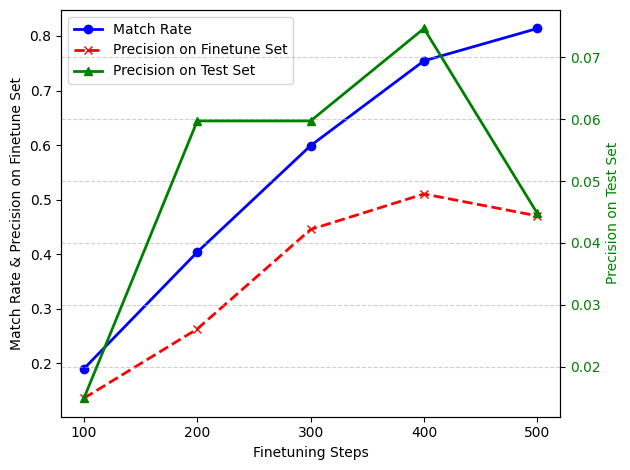

In [8]:
# Data (Replace with your actual data)
finetuning_steps = [100, 200, 300, 400, 500]
m_r = [
    match_rate(f"../data/pairs{x}.json", "../data/cat2list.json")
    for x in finetuning_steps
]
prec = [
    precision(f"../data/pairs{x}.json", "../data/new_categories.csv")
    for x in finetuning_steps
]
prec_test = [
    precision(f"../data/pairs{x}.json", "../data/category_triplets5.csv")
    for x in finetuning_steps
]

# Create figure and primary y-axis
fig, ax1 = plt.subplots()

# Plot Match Rate and Precision on Fine-tune Set
ax1.plot(finetuning_steps, m_r, "b-o", label="Match Rate", linewidth=2)
ax1.plot(finetuning_steps, prec, "r--x", label="Precision on Finetune Set", linewidth=2)

ax1.set_xlabel("Finetuning Steps")
ax1.set_ylabel("Match Rate & Precision on Finetune Set", color="black")
ax1.tick_params(axis="y", labelcolor="black")

ax1.set_xticks(finetuning_steps)

# Add legend for the left y-axis
lines1, labels1 = ax1.get_legend_handles_labels()

# Secondary y-axis for Recall on Test Set
ax2 = ax1.twinx()
ax2.plot(finetuning_steps, prec_test, "g-^", label="Precision on Test Set", linewidth=2)
ax2.set_ylabel("Precision on Test Set", color="green")
ax2.tick_params(axis="y", labelcolor="green")

# Add legend for the right y-axis
lines2, labels2 = ax2.get_legend_handles_labels()

# Combine legends
ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")
# Grid and Layout
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("plot.png", format="png")
# Show the plot
plt.show()